In [0]:
from fastai.tabular import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [0]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [0]:
class BatchSwapNoise(nn.Module):
    """Swap Noise module"""

    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            idx = torch.add(torch.arange(x.nelement()),
                            (torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor) *
                             (mask.type(torch.LongTensor) * x.size(1))).view(-1))
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.view(-1)[idx].view(x.size())
        else:
            return x

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise = BatchSwapNoise(0.20)
        self.encoder = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 200),
            nn.ReLU(True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 300),
            nn.ReLU(True),
            nn.BatchNorm1d(300),
            nn.Linear(300, 300),
            nn.ReLU(True),
            nn.BatchNorm1d(300),
            nn.Linear(300, 300),
            nn.ReLU(True),
            nn.BatchNorm1d(42)
        )


    def forward(self, xb): 
        encoder = self.encoder(self.noise(xb))
        return encoder

In [0]:
class myTabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.AutoEncoder = Autoencoder()
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [0]:
def tabular_learner(data:DataBunch, layers:Collection[int], emb_szs:Dict[str,int]=None, metrics=None,
        ps:Collection[float]=None, emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, **learn_kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    model = myTabularModel(emb_szs, len(data.cont_names), out_sz=data.c, layers=layers, ps=ps, emb_drop=emb_drop,
                         y_range=y_range, use_bn=use_bn)
    return Learner(data, model, metrics=metrics, **learn_kwargs)

In [0]:
def calcHiddenLayer(data, alpha, ip, op, numHiddenLayers):
  return [(len(data.train_ds)//(alpha*(ip+op)))//numHiddenLayers]*numHiddenLayers

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                          # .add_test(test)
                           .databunch())

In [0]:
learn = tabular_learner(data, layers=[], metrics=accuracy)

In [22]:
learn.model

myTabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (AutoEncoder): Autoencoder(
    (noise): BatchSwapNoise()
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): ReLU(inplace)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=32, out_features=200, bias=True)
      (4): ReLU(inplace)
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=200, out_features=300, bias=True)
      (7): ReLU(inplace)
      (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Linear(in_features=3

In [0]:
learn = tabular_learner(data, layers=calcHiddenLayer(data, 3, 42, 2, 2), metrics=accuracy)

In [24]:
learn.model

myTabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (AutoEncoder): Autoencoder(
    (noise): BatchSwapNoise()
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): ReLU(inplace)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=32, out_features=200, bias=True)
      (4): ReLU(inplace)
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=200, out_features=300, bias=True)
      (7): ReLU(inplace)
      (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Linear(in_features=3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


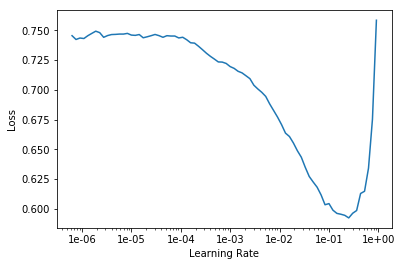

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.390673,0.403616,0.790000,00:04
1,0.366895,0.390479,0.805000,00:04
2,0.370506,0.389576,0.800000,00:04
3,0.354369,0.386487,0.815000,00:04
4,0.362150,0.409555,0.830000,00:04
5,0.357786,0.366187,0.840000,00:04
6,0.353295,0.353717,0.830000,00:04
7,0.353457,0.363840,0.845000,00:04
8,0.363246,0.356241,0.830000,00:04
9,0.355413,0.342809,0.855000,00:05


In [0]:
learn.save('86')

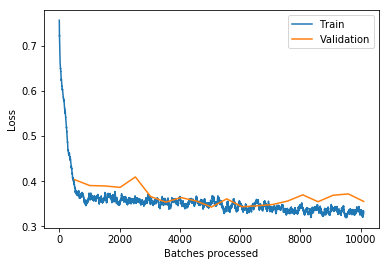

In [33]:
learn.recorder.plot_losses()

In [0]:
def PredictTest(df, learner, column):
  i = 0
  for x in range(len(df)):
    if(str(learner.predict(df.iloc[x])[0]) == df[column].iloc[x]):
      i+=1
    if(x%500 == 0 and x > 0):
      print(i/x)
  return i/len(df)

In [0]:
test = df.iloc[800:1000]

In [36]:
len(test)

200

In [37]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
800,45,Private,96975,Some-college,NaN,Divorced,Handlers-cleaners,Unmarried,White,Female,0,0,40,United-States,<50k
801,46,Self-emp-inc,192779,Prof-school,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024,0,60,United-States,>=50k
802,36,Private,376455,Assoc-voc,NaN,Divorced,NaN,Not-in-family,White,Male,0,0,38,United-States,<50k
803,25,Federal-gov,50053,Bachelors,NaN,Never-married,Tech-support,Not-in-family,White,Male,0,0,45,United-States,<50k
804,37,Private,164526,Bachelors,NaN,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<50k


In [38]:
PredictTest(test, learn, 'salary')

0.86